##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# {TF Probability, R, Stan} 中的线性混合效应回归

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/probability/examples/HLM_TFP_R_Stan"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/HLM_TFP_R_Stan.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a> </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/HLM_TFP_R_Stan.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/probability/examples/HLM_TFP_R_Stan.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

## 1  简介

在此 colab 中，我们将线性混合效应回归模型拟合到流行的小数据集。我们将使用 R 的 `lme4`、Stan 的混合效应软件包和 TensorFlow Probability (TFP) 基元对此进行三次拟合。我们通过显示全部三次拟合均给出大致相同的拟合参数和后验分布来得出结论。

我们的主要结论是，TFP 具有拟合类 HLM 模型所需的通用部分，并且它产生的结果与其他软件包（即 `lme4` 和 `rstanarm`）一致。此 colab 并不能准确反映所比较的任何软件包的计算效率。

In [ ]:
%matplotlib inline

import os
from six.moves import urllib
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.core.pylabtools import figsize
figsize(11, 9)

import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

## 2  分层线性模型


为了比较 R、Stan 和 TFP，我们将[分层线性模型](https://en.wikipedia.org/wiki/Multilevel_model) (HLM) 拟合到 Gelman 等人编写的 [*Bayesian Data Analysis*](http://www.stat.columbia.edu/~gelman/book/)（第二版第 559 页；第三版第 250 页）中常用的 [Radon 数据集](http://www.stat.columbia.edu/~gelman/arm/examples/radon/)。


我们假设以下生成模型：

$$\begin{align*} \text{for } &amp; c=1\ldots \text{NumCounties}:\ &amp; \beta_c \sim \text{Normal}\left(\text{loc}=0, \text{scale}=\sigma_C  \right) \ \text{for } &amp; i=1\ldots \text{NumSamples}:\ &amp;\eta_i = \underbrace{\omega_0 + \omega_1 \text{Floor}<em data-md-type="emphasis">i}</em>\text{fixed effects} + \underbrace{\beta_{ \text{County}<em data-md-type="emphasis">i} \log( \text{UraniumPPM}</em>{\text{County}<em data-md-type="emphasis">i}))}</em>\text{random effects} \ &amp;\log(\text{Radon}_i) \sim \text{Normal}(\text{loc}=\eta_i , \text{scale}=\sigma_N) \end{align*}$$


在 R 的 `lme4`“波浪符号”中，此模型相当于：

> `log_radon ~ 1 + floor +  (0 + log_uranium_ppm | county)`


我们将使用 ${\beta_c}_{c=1}^\text{NumCounties}$ 的后验分布（以证据为条件）找到 $\omega, \sigma_C, \sigma_N$ 的 MLE。

对于本质上相同但*具有*随机截距的模型，请参阅*[附录 A](#scrollTo=tsXhZ4rtNUXL)*。

有关 HLM 的更一般规范，请参阅*[附录 B](#scrollTo=H0w7ofFvNsxi)*。

## 3  数据整理

在本部分中，我们获得 [`radon` 数据集](http://www.stat.columbia.edu/~gelman/arm/examples/radon/)并进行一些最少的预处理以使其符合我们假设的模型。

In [ ]:
def load_and_preprocess_radon_dataset(state='MN'):
  """Preprocess Radon dataset as done in "Bayesian Data Analysis" book.
  
  We filter to Minnesota data (919 examples) and preprocess to obtain the
  following features:
  - `log_uranium_ppm`: Log of soil uranium measurements.
  - `county`: Name of county in which the measurement was taken.
  - `floor`: Floor of house (0 for basement, 1 for first floor) on which the
    measurement was taken.

  The target variable is `log_radon`, the log of the Radon measurement in the
  house.
  """
  ds = tfds.load('radon', split='train')
  radon_data = tfds.as_dataframe(ds)
  radon_data.rename(lambda s: s[9:] if s.startswith('feat') else s, axis=1, inplace=True)
  df = radon_data[radon_data.state==state.encode()].copy()

  # For any missing or invalid activity readings, we'll use a value of `0.1`.
  df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)
  # Make county names look nice. 
  df['county'] = df.county.apply(lambda s: s.decode()).str.strip().str.title()
  # Remap categories to start from 0 and end at max(category).
  county_name = sorted(df.county.unique())
  df['county'] = df.county.astype(
      pd.api.types.CategoricalDtype(categories=county_name)).cat.codes
  county_name = list(map(str.strip, county_name))

  df['log_radon'] = df['radon'].apply(np.log)
  df['log_uranium_ppm'] = df['Uppm'].apply(np.log)
  df = df[['idnum', 'log_radon', 'floor', 'county', 'log_uranium_ppm']]

  return df, county_name

In [ ]:
radon, county_name = load_and_preprocess_radon_dataset()

In [ ]:
# We'll use the following directory to store our preprocessed dataset.
CACHE_DIR = os.path.join(os.sep, 'tmp', 'radon')

# Save processed data. (So we can later read it in R.)
if not tf.gfile.Exists(CACHE_DIR):
  tf.gfile.MakeDirs(CACHE_DIR)
with tf.gfile.Open(os.path.join(CACHE_DIR, 'radon.csv'), 'w') as f:
  radon.to_csv(f, index=False)

### 3.1  了解您的数据

在本部分中，我们将探索 `radon` 数据集，以便更好地了解所提出模型为何合理。

In [ ]:
radon.head()

log_radon  floor  county  log_uranium_ppm
0   0.788457      1       0        -0.689048
1   0.788457      0       0        -0.689048
2   1.064711      0       0        -0.689048
3   0.000000      0       0        -0.689048
4   1.131402      0       1        -0.847313

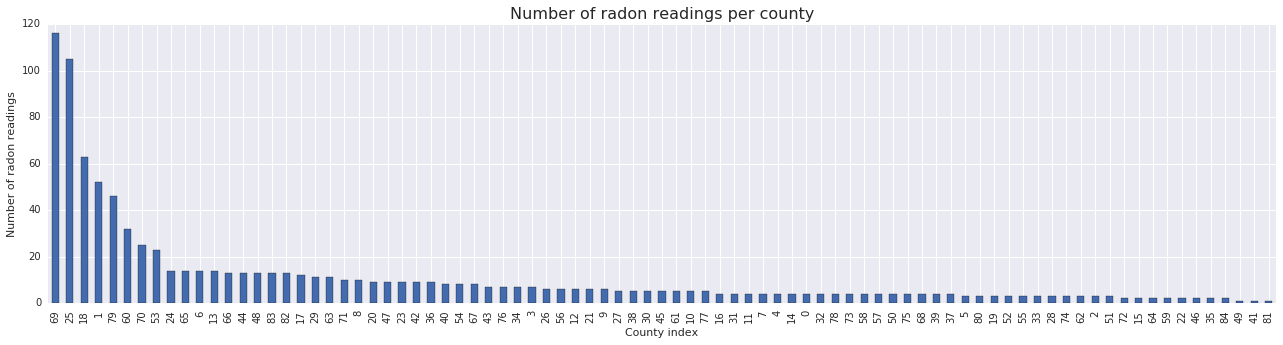

In [ ]:
fig, ax = plt.subplots(figsize=(22, 5));
county_freq = radon['county'].value_counts()
county_freq.plot(kind='bar', color='#436bad');
plt.xlabel('County index')
plt.ylabel('Number of radon readings')
plt.title('Number of radon readings per county', fontsize=16)
county_freq = np.array(zip(county_freq.index, county_freq.values))  # We'll use this later.

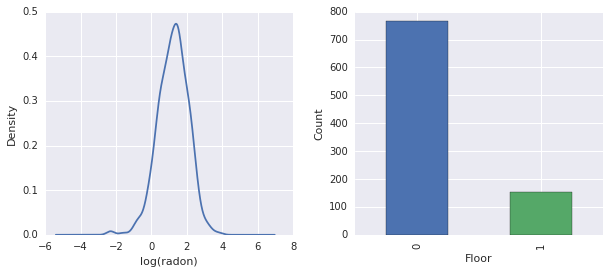

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=[10, 4]);

radon['log_radon'].plot(kind='density', ax=ax[0]);
ax[0].set_xlabel('log(radon)')

radon['floor'].value_counts().plot(kind='bar', ax=ax[1]);
ax[1].set_xlabel('Floor');
ax[1].set_ylabel('Count');

fig.subplots_adjust(wspace=0.25)

结论：

- 存在 85 个县的长尾。（在 GLMM 中很常见。）
- 实际上 $\log(\text{Radon})$ 是不受约束的。（因此线性回归可能有意义。）
- 读数大多在第 $0$ 层；没有读数高于第 $1$ 层。（因此我们的固定效应只有两个权重。）


## 4  R 中的 HLM

在本部分中，我们使用 R 的 [`lme4`](https://cran.r-project.org/web/packages/lme4/index.html) 软件包来拟合上述概率模型。

**注：要执行此部分，您必须切换到 `R` colab 运行时。**

In [ ]:
suppressMessages({
  library('bayesplot')
  library('data.table')
  library('dplyr')
  library('gfile')
  library('ggplot2')
  library('lattice')
  library('lme4')
  library('plyr')
  library('rstanarm')
  library('tidyverse')
  RequireInitGoogle()
})

In [ ]:
data = read_csv(gfile::GFile('/tmp/radon/radon.csv'))

Parsed with column specification:
cols(
  log_radon = col_double(),
  floor = col_integer(),
  county = col_integer(),
  log_uranium_ppm = col_double()
)


In [ ]:
head(data)

# A tibble: 6 x 4
  log_radon floor county log_uranium_ppm
      <dbl> <int>  <int>           <dbl>
1     0.788     1      0          -0.689
2     0.788     0      0          -0.689
3     1.06      0      0          -0.689
4     0         0      0          -0.689
5     1.13      0      1          -0.847
6     0.916     0      1          -0.847

In [ ]:
# https://github.com/stan-dev/example-models/wiki/ARM-Models-Sorted-by-Chapter
radon.model <- lmer(log_radon ~ 1 + floor  + (0 + log_uranium_ppm | county), data = data)

In [ ]:
summary(radon.model)

Linear mixed model fit by REML ['lmerMod']
Formula: log_radon ~ 1 + floor + (0 + log_uranium_ppm | county)
   Data: data

REML criterion at convergence: 2166.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5202 -0.6064  0.0107  0.6334  3.4111 

Random effects:
 Groups   Name            Variance Std.Dev.
 county   log_uranium_ppm 0.7545   0.8686  
 Residual                 0.5776   0.7600  
Number of obs: 919, groups:  county, 85

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.47585    0.03899   37.85
floor       -0.67974    0.06963   -9.76

Correlation of Fixed Effects:
      (Intr)
floor -0.330

$county


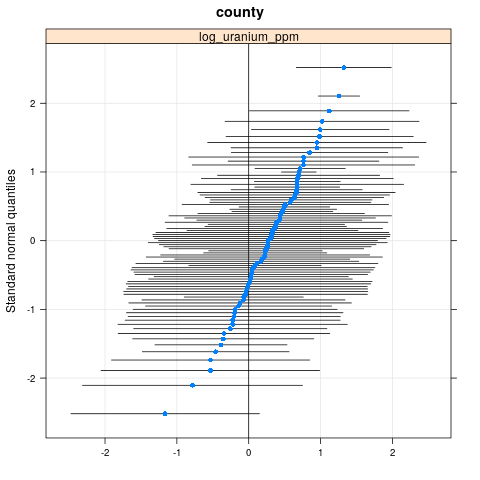

In [ ]:
qqmath(ranef(radon.model, condVar=TRUE))

In [ ]:
write.csv(as.data.frame(ranef(radon.model, condVar = TRUE)), '/tmp/radon/lme4_fit.csv')

## 5  Stan 中的 HLM


在本部分中，我们使用 [rstanarm](http://mc-stan.org/users/interfaces/rstanarm) 来拟合 Stan 模型，采用的公式/语法与上述 `lme4` 模型相同。

与 `lme4` 和下面的 TF 模型不同的是，`rstanarm` 是一个完全贝叶斯模型，即所有参数都假定从正态分布中抽取，而参数本身则从分布中抽取。

**注：要执行此部分，您必须切换到 `R` colab 运行时。**

In [ ]:
fit <- stan_lmer(log_radon ~ 1 + floor  + (0 + log_uranium_ppm | county), data = data)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1, Iteration: 2000 / 2000 [100%]  (Sampling)
 Elapsed Time: 7.73495 seconds (Warm-up)
               2.98852 seconds (Sampling)
               10.7235 seconds (Total)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 2, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 2, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 2, Iteration:  600 / 2000 

**注**：运行时来自单个 CPU 内核。（此 colab 并不适合忠实表示 Stan 或 TFP 运行时。）

In [ ]:
fit

stan_lmer(formula = log_radon ~ 1 + floor + (0 + log_uranium_ppm | 
    county), data = data)

Estimates:
            Median MAD_SD
(Intercept)  1.5    0.0  
floor       -0.7    0.1  
sigma        0.8    0.0  

Error terms:
 Groups   Name            Std.Dev.
 county   log_uranium_ppm 0.87    
 Residual                 0.76    
Num. levels: county 85 

Sample avg. posterior predictive 
distribution of y (X = xbar):
         Median MAD_SD
mean_PPD 1.2    0.0   

Observations: 919  Number of unconstrained parameters: 90 

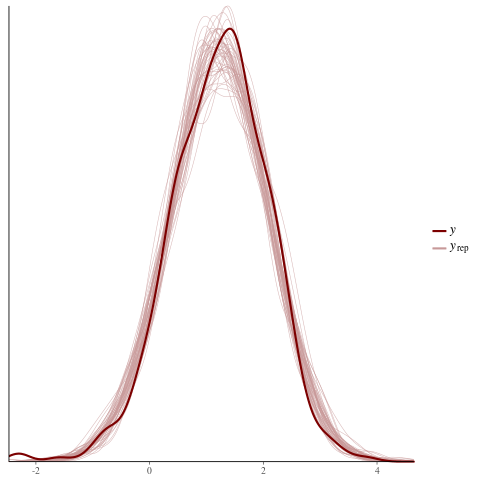

In [ ]:
color_scheme_set("red")
ppc_dens_overlay(y = fit$y,
                 yrep = posterior_predict(fit, draws = 50))

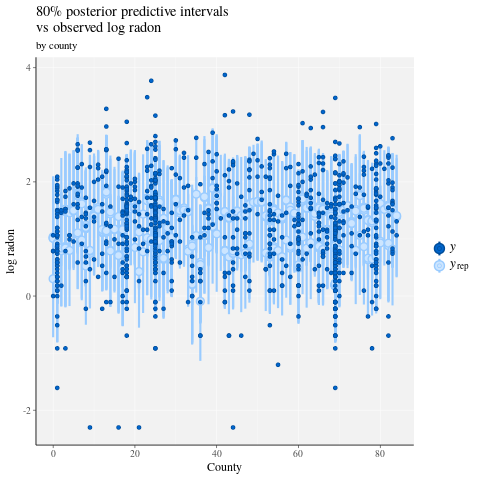

In [ ]:
color_scheme_set("brightblue")
ppc_intervals(
  y = data$log_radon,
  yrep = posterior_predict(fit),
  x = data$county,
  prob = 0.8
) +
  labs(
    x = "County",
    y = "log radon",
    title = "80% posterior predictive intervals \nvs observed log radon",
    subtitle = "by county"
  ) +
  panel_bg(fill = "gray95", color = NA) +
  grid_lines(color = "white")

In [ ]:
# Write the posterior samples (4000 for each variable) to a CSV.
write.csv(tidy(as.matrix(fit)), "/tmp/radon/stan_fit.csv")

**注：切换回 Python TF 内核运行时。**

In [ ]:
with tf.gfile.Open('/tmp/radon/lme4_fit.csv', 'r') as f:
  lme4_fit = pd.read_csv(f, index_col=0)

In [ ]:
lme4_fit.head()

grpvar             term  grp   condval    condsd
1  county  log_uranium_ppm    0  0.667653  0.465584
2  county  log_uranium_ppm    1  0.697805  0.123133
3  county  log_uranium_ppm    2 -0.010856  0.847489
4  county  log_uranium_ppm    3 -0.068872  0.422883
5  county  log_uranium_ppm    4  0.036075  0.825677

从 lme4 检索组随机效应的点估计值和条件标准差，以便稍后呈现。

In [ ]:
posterior_random_weights_lme4 = np.array(lme4_fit.condval, dtype=np.float32)
lme4_prior_scale = np.array(lme4_fit.condsd, dtype=np.float32)
print(posterior_random_weights_lme4.shape, lme4_prior_scale.shape)

(85,) (85,)


使用 lme4 估计均值和标准差为县权重抽取样本。

In [ ]:
with tf.Session() as sess:
  lme4_dist = tfp.distributions.Independent(
      tfp.distributions.Normal(
          loc=posterior_random_weights_lme4,
          scale=lme4_prior_scale),
      reinterpreted_batch_ndims=1)
  posterior_random_weights_lme4_final_ = sess.run(lme4_dist.sample(4000))

In [ ]:
posterior_random_weights_lme4_final_.shape

(4000, 85)

我们还从 Stan 拟合中检索县权重的后验样本。

In [ ]:
with tf.gfile.Open('/tmp/radon/stan_fit.csv', 'r') as f:
  samples = pd.read_csv(f, index_col=0)

In [ ]:
samples.head()

X.Intercept.     floor  b.log_uranium_ppm.county.0.  \
1      1.450331 -0.757375                     1.093099   
2      1.453383 -0.659085                     0.560266   
3      1.460351 -0.804513                     1.145694   
4      1.438725 -0.565721                     0.204148   
5      1.457569 -0.658910                     0.140554   

   b.log_uranium_ppm.county.1.  b.log_uranium_ppm.county.2.  \
1                     0.603985                    -0.661680   
2                     0.580569                     0.419441   
3                     0.705337                     2.216364   
4                     0.810580                    -1.982466   
5                     0.593056                    -2.618940   

   b.log_uranium_ppm.county.3.  b.log_uranium_ppm.county.4.  \
1                    -0.667052                     0.549178   
2                    -0.154925                    -1.263534   
3                    -1.044031                     1.510397   
4                     1.044825                    -1.339406   
5                     0.484812                    -0.417834   

   b.log_uranium_ppm.county.5.  b.log_uranium_ppm.county.6.  \
1                    -0.150145                     1.486173   
2                     0.166291                     1.534917   
3                    -0.472675                     0.427448   
4                     0.643384                     2.379191   
5                     0.735558                     1.693997   

   b.log_uranium_ppm.county.7.    ...     b.log_uranium_ppm.county.76.  \
1                     0.053578    ...                         0.323107   
2                     1.141392    ...                         0.306941   
3                     0.940869    ...                         1.941637   
4                     0.295981    ...                        -0.832814   
5                     0.230496    ...                        -0.608215   

   b.log_uranium_ppm.county.77.  b.log_uranium_ppm.county.78.  \
1                      0.282121                     -0.188251   
2                      0.331696                      0.614852   
3                      0.188311                     -0.690044   
4                      0.246694                     -0.801078   
5                     -0.586245                      0.204547   

   b.log_uranium_ppm.county.79.  b.log_uranium_ppm.county.80.  \
1                      0.889385                      1.008348   
2                      0.153913                      1.253688   
3                      0.946370                      1.626093   
4                      0.072430                      0.108882   
5                      0.350195                      0.164781   

   b.log_uranium_ppm.county.81.  b.log_uranium_ppm.county.82.  \
1                      0.429430                      0.404690   
2                      0.246746                      0.849947   
3                      0.930756                      0.141125   
4                     -0.203805                      0.443365   
5                     -0.009945                      0.023533   

   b.log_uranium_ppm.county.83.  b.log_uranium_ppm.county.84.     sigma  
1                      0.112424                     -0.071612  0.778706  
2                     -1.399027                     -1.697360  0.754960  
3                      0.041392                     -0.135538  0.763605  
4                     -0.901578                     -0.063022  0.750404  
5                     -0.177017                     -0.425871  0.755898  

[5 rows x 88 columns]

In [ ]:
posterior_random_weights_cols = [
    col for col in samples.columns if 'b.log_uranium_ppm.county' in col
]
posterior_random_weights_final_stan = samples[
    posterior_random_weights_cols].values
print(posterior_random_weights_final_stan.shape)

(4000, 85)


[此 Stan 示例](https://github.com/stan-dev/example-models/blob/master/ARM/Ch.16/radon.3.stan)展示了如何以更接近 TFP 的方式（即通过直接指定概率模型）实现 LMER。

## 6  TF Probability 中的 HLM

在本部分中，我们将使用低级 TensorFlow Probability 基元 (`Distributions`) 来指定我们的分层线性模型并拟合未知参数。

In [ ]:
# Handy snippet to reset the global graph and global session.
with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  tf.reset_default_graph()
  try:
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession()

### 6.1  指定模型

在本部分中，我们使用 TFP 基元指定[氡线性混合效应模型](#scrollTo=IFC9r-h0XlQ3)。为此，我们指定了两个函数来产生两个 TFP 分布：

- `make_weights_prior`：随机权重的多元正态先验（乘以 $\log(\text{UraniumPPM}_{c_i})$ 以计算线性预测因子）。
- `make_log_radon_likelihood`：每个观察到的 $\log(\text{Radon}_i)$ 因变量的一批 `Normal` 分布。


由于我们将拟合每个分布的参数，因此必须使用 TF 变量（即 [`tf.get_variable`](https://tensorflow.google.cn/api_docs/python/tf/get_variable)）。不过，由于我们希望使用无约束优化，必须找到一种方法来约束实数值以实现必要的语义，例如，表示标准差的正数。 

In [ ]:
inv_scale_transform = lambda y: np.log(y)  # Not using TF here.
fwd_scale_transform = tf.exp

以下函数构建构造我们的先验 $p(\beta|\sigma_C)$，其中 $\beta$ 表示随机效应权重，$\sigma_C$ 表示标准差。

我们使用 `tf.make_template` 来确保对此函数的第一次调用会实例化它使用的 TF 变量，并且所有后续调用都会*重用*变量的当前值。

In [ ]:
def _make_weights_prior(num_counties, dtype):
  """Returns a `len(log_uranium_ppm)` batch of univariate Normal."""
  raw_prior_scale = tf.get_variable(
      name='raw_prior_scale',
      initializer=np.array(inv_scale_transform(1.), dtype=dtype))
  return tfp.distributions.Independent(
      tfp.distributions.Normal(
          loc=tf.zeros(num_counties, dtype=dtype),
          scale=fwd_scale_transform(raw_prior_scale)),
      reinterpreted_batch_ndims=1)


make_weights_prior = tf.make_template(
    name_='make_weights_prior', func_=_make_weights_prior)

以下函数构造我们的似然 $p(y|x,\omega,\beta,\sigma_N)$，其中 $y,x$ 表示响应和证据，$\omega,\beta$ 表示固定和随机效应权重，$\sigma_N$ 表示标准差。

这里我们再次使用 `tf.make_template` 来确保在各调用之间重用 TF 变量。

In [ ]:
def _make_log_radon_likelihood(random_effect_weights, floor, county,
                               log_county_uranium_ppm, init_log_radon_stddev):
  raw_likelihood_scale = tf.get_variable(
      name='raw_likelihood_scale',
      initializer=np.array(
          inv_scale_transform(init_log_radon_stddev), dtype=dtype))
  fixed_effect_weights = tf.get_variable(
      name='fixed_effect_weights', initializer=np.array([0., 1.], dtype=dtype))
  fixed_effects = fixed_effect_weights[0] + fixed_effect_weights[1] * floor
  random_effects = tf.gather(
      random_effect_weights * log_county_uranium_ppm,
      indices=tf.to_int32(county),
      axis=-1)
  linear_predictor = fixed_effects + random_effects
  return tfp.distributions.Normal(
      loc=linear_predictor, scale=fwd_scale_transform(raw_likelihood_scale))


make_log_radon_likelihood = tf.make_template(
    name_='make_log_radon_likelihood', func_=_make_log_radon_likelihood)

最后，我们使用先验和似然生成器来构造联合对数密度。

In [ ]:
def joint_log_prob(random_effect_weights, log_radon, floor, county,
                   log_county_uranium_ppm, dtype):
  num_counties = len(log_county_uranium_ppm)
  rv_weights = make_weights_prior(num_counties, dtype)
  rv_radon = make_log_radon_likelihood(
      random_effect_weights,
      floor,
      county,
      log_county_uranium_ppm,
      init_log_radon_stddev=radon.log_radon.values.std())
  return (rv_weights.log_prob(random_effect_weights)
          + tf.reduce_sum(rv_radon.log_prob(log_radon), axis=-1))

### 6.2  训练（期望最大化的随机逼近）

为了拟合我们的线性混合效应回归模型，我们将使用随机逼近版本的期望最大化算法 (SAEM)。基本理念是使用来自后验的样本来逼近预期的联合对数密度 (E-step)。随后，我们找到使此计算最大化的参数 (M-step)。更具体地说，通过以下公式给出定点迭代：

$$\begin{align*} \text{E}[ \log p(x, Z | \theta) | \theta_0] &amp;\approx \frac{1}{M} \sum_{m=1}^M \log p(x, z_m | \theta), \quad Z_m\sim p(Z | x, \theta_0) &amp;&amp; \text{E-step}\ &amp;=: Q_M(\theta, \theta_0) \ \theta_0 &amp;= \theta_0 - \eta \left.\nabla_\theta Q_M(\theta, \theta_0)\right|_{\theta=\theta_0} &amp;&amp; \text{M-step} \end{align*}$$

其中 $x$ 表示证据，$Z$ 是一些需要被边缘化的潜在变量，而 $\theta,\theta_0$ 是可能的参数化。

有关更详尽的解释，请参阅 [Bernard Delyon、Marc Lavielle、Eric 和 Moulines 编写的*随机逼近版本的 EM 算法的收敛*（Ann. Statist.，1999 年）](https://projecteuclid.org/euclid.aos/1018031103)。

要计算 E-step，我们需要从后验抽样。由于不太容易从我们的后验中抽样，因此我们使用汉密尔顿蒙特卡洛 (HMC)。HMC 是一种马尔科夫链蒙特卡洛程序，它使用非归一化后验对数密度的梯度（wrt 状态，而不是参数）来提出新样本。


指定非归一化后验对数密度十分简单，它只是我们希望以任何条件“固定”的联合对数密度。

In [ ]:
# Specify unnormalized posterior.

dtype = np.float32

log_county_uranium_ppm = radon[
    ['county', 'log_uranium_ppm']].drop_duplicates().values[:, 1]
log_county_uranium_ppm = log_county_uranium_ppm.astype(dtype)

def unnormalized_posterior_log_prob(random_effect_weights):
  return joint_log_prob(
      random_effect_weights=random_effect_weights,
      log_radon=dtype(radon.log_radon.values),
      floor=dtype(radon.floor.values),
      county=np.int32(radon.county.values),
      log_county_uranium_ppm=log_county_uranium_ppm,
      dtype=dtype)

我们现在通过创建 HMC 转换内核来完成 E-step 设置。

注释：

- 我们使用 `state_stop_gradient=True` 来防止 M-step 通过从 MCMC 抽取进行反向传播。（回想一下，我们不需要反向传播，因为我们的 E-step 是在*之前*最知名的 estimator 中有意参数化的。）

- 我们使用 [`tf.placeholder`](https://tensorflow.google.cn/api_docs/python/tf/placeholder)，这样当我们最终执行 TF 计算图时，可以提供前一次迭代的随机 MCMC 样本作为下一次迭代的链值。

- 我们使用 TFP 的自适应 `step_size` 启发式算法，`tfp.mcmc.hmc_step_size_update_fn`。

In [ ]:
# Set-up E-step.

step_size = tf.get_variable(
    'step_size',
    initializer=np.array(0.2, dtype=dtype),
    trainable=False)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_posterior_log_prob,
    num_leapfrog_steps=2,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=None),
    state_gradients_are_stopped=True)

init_random_weights = tf.placeholder(dtype, shape=[len(log_county_uranium_ppm)])

posterior_random_weights, kernel_results = tfp.mcmc.sample_chain(
    num_results=3,
    num_burnin_steps=0,
    num_steps_between_results=0,
    current_state=init_random_weights,
    kernel=hmc)

我们现在设置 M-step。这本质上与可能在 TF 中进行的优化相同。

In [ ]:
# Set-up M-step.

loss = -tf.reduce_mean(kernel_results.accepted_results.target_log_prob)

global_step = tf.train.get_or_create_global_step()

learning_rate = tf.train.exponential_decay(
    learning_rate=0.1,
    global_step=global_step,
    decay_steps=2,
    decay_rate=0.99)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

我们以一些内务处理任务结束。我们必须告诉 TF 所有变量都已初始化。此外，我们还为 TF 变量创建了句柄，以便可以在程序的每次迭代中 `print` 它们的值。 

In [ ]:
# Initialize all variables.

init_op = tf.initialize_all_variables()

In [ ]:
# Grab variable handles for diagnostic purposes.

with tf.variable_scope('make_weights_prior', reuse=True):
  prior_scale = fwd_scale_transform(tf.get_variable(
      name='raw_prior_scale', dtype=dtype))
  
with tf.variable_scope('make_log_radon_likelihood', reuse=True):
  likelihood_scale = fwd_scale_transform(tf.get_variable(
      name='raw_likelihood_scale', dtype=dtype))
  fixed_effect_weights = tf.get_variable(
      name='fixed_effect_weights', dtype=dtype)

### 6.3  执行

在本部分中，我们执行 SAEM TF 计算图。这里的主要技巧是将我们从 HMC 内核中最后一次抽取的数据馈送到下一次迭代中。我们通过在 `sess.run` 调用中使用 `feed_dict` 来实现此目的。

In [ ]:
init_op.run()
w_ = np.zeros([len(log_county_uranium_ppm)], dtype=dtype)

In [ ]:
%%time
maxiter = int(1500)
num_accepted = 0
num_drawn = 0
for i in range(maxiter):
  [
      _,
      global_step_,
      loss_,
      posterior_random_weights_,
      kernel_results_,
      step_size_,
      prior_scale_,
      likelihood_scale_,
      fixed_effect_weights_,
  ] = sess.run([
      train_op,
      global_step,
      loss,
      posterior_random_weights,
      kernel_results,
      step_size,
      prior_scale,
      likelihood_scale,
      fixed_effect_weights,
  ], feed_dict={init_random_weights: w_})
  w_ = posterior_random_weights_[-1, :]
  num_accepted += kernel_results_.is_accepted.sum()
  num_drawn += kernel_results_.is_accepted.size
  acceptance_rate = num_accepted / num_drawn
  if i % 100 == 0 or i == maxiter - 1:
    print('global_step:{:>4}  loss:{: 9.3f}  acceptance:{:.4f}  '
          'step_size:{:.4f}  prior_scale:{:.4f}  likelihood_scale:{:.4f}  '
          'fixed_effect_weights:{}'.format(
              global_step_, loss_.mean(), acceptance_rate, step_size_,
              prior_scale_, likelihood_scale_, fixed_effect_weights_))              

global_step:   0  loss: 1966.948  acceptance:1.0000  step_size:0.2000  prior_scale:1.0000  likelihood_scale:0.8529  fixed_effect_weights:[ 0.  1.]
global_step: 100  loss: 1165.385  acceptance:0.6205  step_size:0.2040  prior_scale:0.9568  likelihood_scale:0.7611  fixed_effect_weights:[ 1.47523439 -0.66043079]
global_step: 200  loss: 1149.851  acceptance:0.6766  step_size:0.2081  prior_scale:0.7465  likelihood_scale:0.7665  fixed_effect_weights:[ 1.48918796 -0.67058587]
global_step: 300  loss: 1163.464  acceptance:0.6811  step_size:0.2040  prior_scale:0.8445  likelihood_scale:0.7594  fixed_effect_weights:[ 1.46291411 -0.67586178]
global_step: 400  loss: 1158.846  acceptance:0.6808  step_size:0.2081  prior_scale:0.8377  likelihood_scale:0.7574  fixed_effect_weights:[ 1.47349834 -0.68823022]
global_step: 500  loss: 1154.193  acceptance:0.6766  step_size:0.1961  prior_scale:0.8546  likelihood_scale:0.7564  fixed_effect_weights:[ 1.47703862 -0.67521363]
global_step: 600  loss: 1163.903  acce

看起来在大约 1500 步之后，我们对参数的估计已经稳定下来。

### 6.4  结果

现在，我们已经拟合了参数，我们来生成大量后验样本并研究结果。

In [ ]:
%%time
posterior_random_weights_final, kernel_results_final = tfp.mcmc.sample_chain(
    num_results=int(15e3),
    num_burnin_steps=int(1e3),
    current_state=init_random_weights,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unnormalized_posterior_log_prob,
      num_leapfrog_steps=2,
      step_size=step_size))

[
    posterior_random_weights_final_,
    kernel_results_final_,
] = sess.run([
    posterior_random_weights_final,
    kernel_results_final,
], feed_dict={init_random_weights: w_})

CPU times: user 1min 42s, sys: 26.6 s, total: 2min 8s
Wall time: 35.1 s


In [ ]:
print('prior_scale: ', prior_scale_)
print('likelihood_scale: ', likelihood_scale_)
print('fixed_effect_weights: ', fixed_effect_weights_)
print('acceptance rate final: ', kernel_results_final_.is_accepted.mean())

prior_scale:  0.873799
likelihood_scale:  0.758913
fixed_effect_weights:  [ 1.47624075 -0.67875224]
acceptance rate final:  0.7448


我们现在构造 $\beta_c \log(\text{UraniumPPM}_c)$ 随机效应的盒须图。我们将通过降低县频率来对随机效应排序。

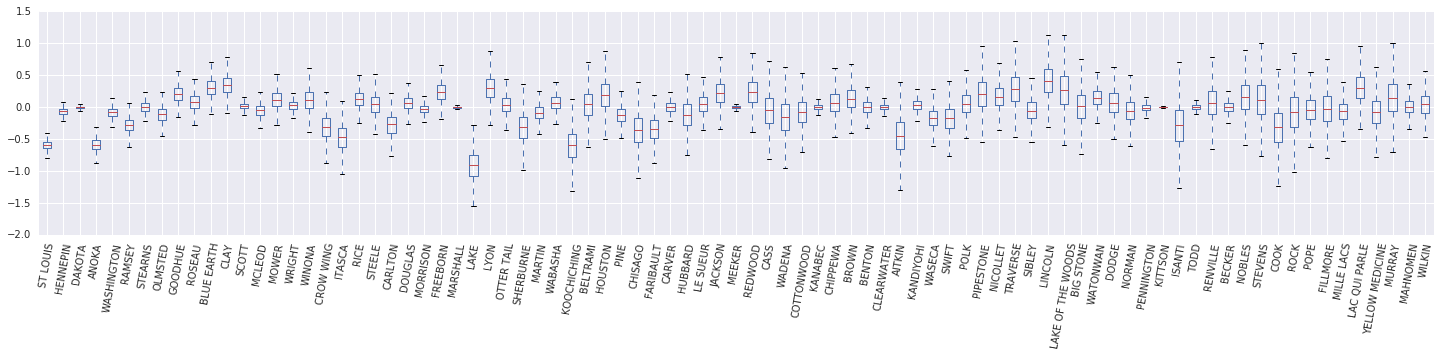

In [ ]:
x = posterior_random_weights_final_ * log_county_uranium_ppm
I = county_freq[:, 0]
x = x[:, I]
cols = np.array(county_name)[I]
pw = pd.DataFrame(x)
pw.columns = cols

fig, ax = plt.subplots(figsize=(25, 4))
ax = pw.boxplot(rot=80, vert=True);

从这张盒须图中，我们观察到县级 $\log(\text{UraniumPPM})$ 随机效应的方差随着该县在数据集中的代表性减少而增大。从直觉上说，这是有道理的，如果针对某个县的证据较少，那么我们对该县影响的确定性应当会降低。

## 7 并排比较

我们现在比较全部三个程序的结果。为此，我们将计算由 Stan 和 TFP 生成的后验样本的非参数估计。此外，我们还将与 R 的 `lme4` 软件包产生的参数（逼近）估计进行比较。

下图描绘了明尼苏达州每个县的每个权重的后验分布。我们显示了 Stan（红色）、TFP（蓝色）和 R 的 `lme4`（橙色）的结果。我们给 Stan 和 TFP 的结果加上阴影，因此预期在两者一致时会看到紫色。为简单起见，我们不给 R 的结果加上阴影。每个子图代表一个县，按光栅扫描顺序（即从左到右，然后从上到下）降序排列。

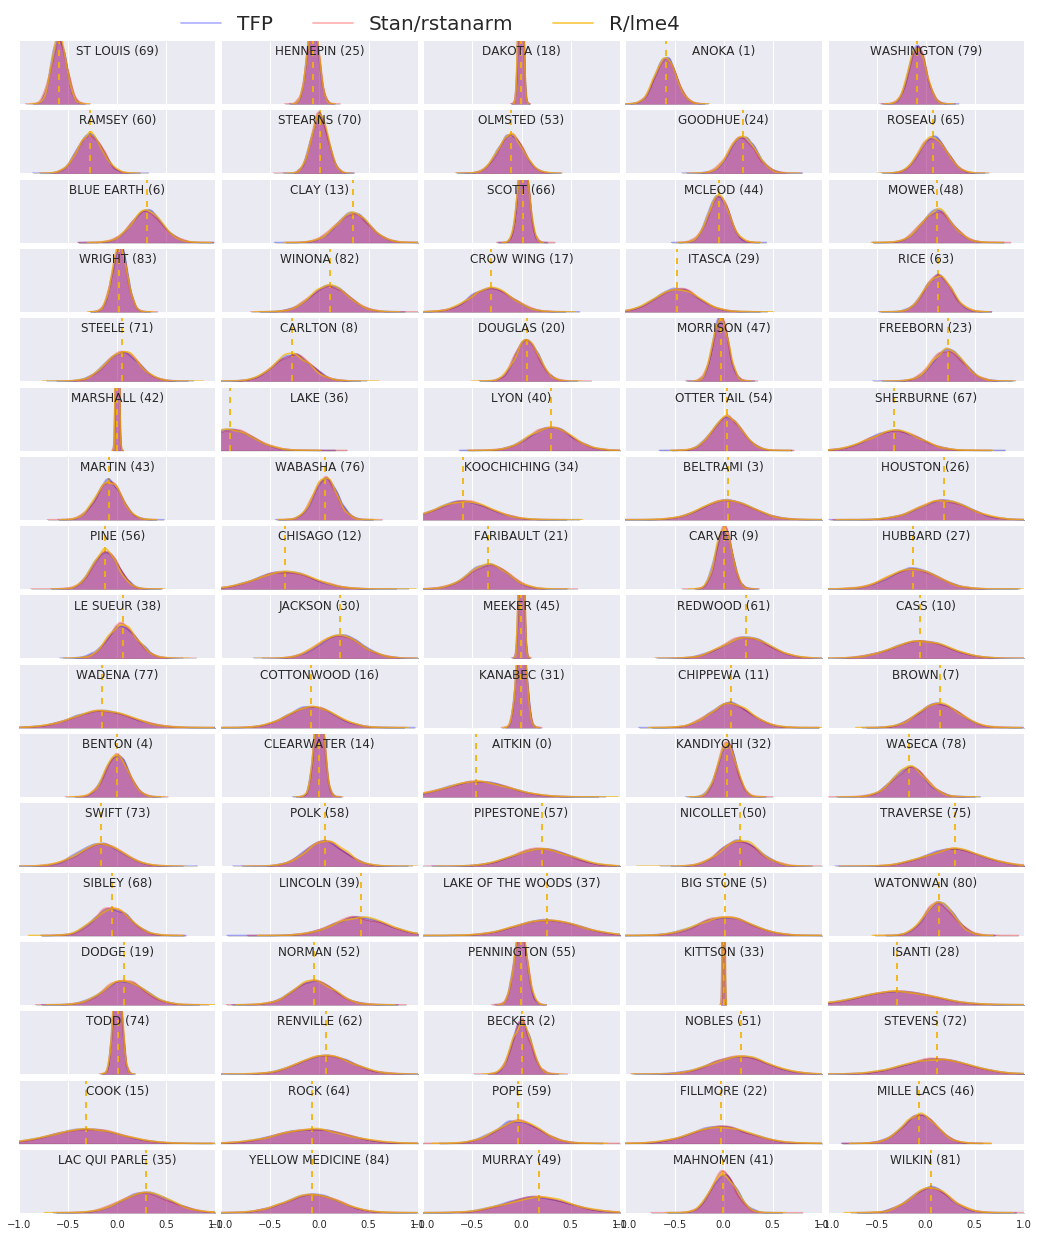

In [ ]:
nrows = 17
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 21), sharey=True, sharex=True)
with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  ii = -1
  for r in range(nrows):
    for c in range(ncols):
      ii += 1
      idx = county_freq[ii, 0]
      sns.kdeplot(
          posterior_random_weights_final_[:, idx] * log_county_uranium_ppm[idx],
          color='blue',
          alpha=.3,
          shade=True,
          label='TFP',
          ax=ax[r][c])
      sns.kdeplot(
          posterior_random_weights_final_stan[:, idx] *
          log_county_uranium_ppm[idx],
          color='red',
          alpha=.3,
          shade=True,
          label='Stan/rstanarm',
          ax=ax[r][c])
      sns.kdeplot(
          posterior_random_weights_lme4_final_[:, idx] *
          log_county_uranium_ppm[idx],
          color='#F4B400',
          alpha=.7,
          shade=False,
          label='R/lme4',
          ax=ax[r][c])
      ax[r][c].vlines(
          posterior_random_weights_lme4[idx] * log_county_uranium_ppm[idx],
          0,
          5,
          color='#F4B400',
          linestyle='--')
      ax[r][c].set_title(county_name[idx] + ' ({})'.format(idx), y=.7)
      ax[r][c].set_ylim(0, 5)
      ax[r][c].set_xlim(-1., 1.)
      ax[r][c].get_yaxis().set_visible(False)
      if ii == 2:
        ax[r][c].legend(bbox_to_anchor=(1.4, 1.7), fontsize=20, ncol=3)
      else:
        ax[r][c].legend_.remove()
  fig.subplots_adjust(wspace=0.03, hspace=0.1)

## 8  结论

在此 colab 中，我们将线性混合效应回归模型拟合到氡数据集。我们尝试了三种不同的软件包：R、Stan 和 TensorFlow Probability。我们最后绘制了由三个不同软件包计算的 85 个后验分布。 

## 附录 A：替代氡 HLM（添加随机截距）

在本部分中，我们会介绍一种替代 HLM，它也具有与每个县相关联的随机截距。

$$\begin{align*} \text{for } &amp; c=1\ldots \text{NumCounties}:\ &amp; \beta_c \sim \text{MultivariateNormal}\left(\text{loc}=\left[ \begin{array}{c} 0 \ 0 \end{array}\right] , \text{scale}=\left[\begin{array}{cc} \sigma_{11}  &amp; 0 \ \sigma_{12} &amp; \sigma_{22} \end{array}\right] \right) \ \text{for } &amp; i=1\ldots \text{NumSamples}:\ &amp; c_i := \text{County}<em data-md-type="emphasis">i \ &amp;\eta_i = \underbrace{\omega_0 + \omega_1\text{Floor}<em data-md-type="emphasis">i \vphantom{\log( \text{CountyUraniumPPM}</em>{c_i}))}}</em>{\text{固定效应}}  + \underbrace{\beta_{c_i,0} + \beta_{c_i,1}\log( \text{CountyUraniumPPM}<em data-md-type="emphasis">{c_i}))}</em>{\text{随机效应}} \ &amp;\log(\text{Radon}_i) \sim \text{Normal}(\text{loc}=\eta_i , \text{scale}=\sigma) \end{align*}$$


在 R 的 `lme4`“波浪符号”中，此模型相当于：

> `log_radon ~ 1 + floor + (1 + log_county_uranium_ppm | county)`

## 附录 B：广义线性混合效应模型

在本部分中，我们将给出正文中使用的分层线性模型的一种更一般的表征。这种更一般的模型被称为[广义线性混合效应模型](https://en.wikipedia.org/wiki/Generalized_linear_mixed_model) (GLMM)。


GLMM 是[广义线性模型](https://en.wikipedia.org/wiki/Generalized_linear_model) (GLM) 的一般化。GLMM 通过在预测的线性响应中加入样本特定的随机噪声来扩展 GLM。这在一定程度上很有用，因为它允许罕见的特征与更常见的特征共享信息。


作为一个生成式过程，广义线性混合效应模型 (GLMM) 的表征为：

\begin{align} \text{for } &amp; r = 1\ldots R:  \hspace{2.45cm}\text{# 对于每个随机效应组}\ &amp;\begin{aligned} \text{for } &amp;c = 1\ldots |C_r|:  \hspace{1.3cm}\text{# 对于 $r$ 组的每个类别（“级别”）}\ &amp;\begin{aligned} \beta_{rc} &amp;\sim \text{MultivariateNormal}(\text{loc}=0_{D_r}, \text{scale}=\Sigma_r^{1/2}) \end{aligned} \end{aligned}\ \text{for } &amp; i = 1 \ldots N:  \hspace{2.45cm}\text{# 对于每个样本}\ &amp;\begin{aligned} &amp;\eta_i = \underbrace{\vphantom{\sum_{r=1}^R}x_i^\top\omega}*\text{固定效应} + \underbrace{\sum*{r=1}^R z_{r,i}^\top \beta_{r,C_r(i) }}*\text{随机效应} \ &amp;Y_i|x_i,\omega,{z*{r,i} , \beta_r}_{r=1}^R \sim \text{Distribution}(\text{mean}= g^{-1}(\eta_i)) \end{aligned} \end{align}


其中：

$$ \begin{align} R &amp;= \text{随机效应组的数量}\ |C_r| &amp;= \text{$r$ 组的类别数量}\ N &amp;= \text{训练样本的数量}\ x_i,\omega &amp;\in \mathbb{R}^{D_0}\ D_0 &amp;= \text{固定效应的数量}\ C_r(i) &amp;= \text{第 $i$ 个样本的类别（$r$ 组下）}\ z_{r,i} &amp;\in \mathbb{R}^{D_r}\ D_r &amp;= \text{与 $r$ 组相关的随机效应数量}\ \Sigma_{r} &amp;\in {S\in\mathbb{R}^{D_r \times D_r} : S \succ 0 }\ \eta_i\mapsto g^{-1}(\eta_i) &amp;= \mu_i，\text{反联系函数}\ \text{Distribution} &amp;=\text{某个只能通过其均值来参数化的分布} \end{align} $$


换句话说，这意味着每个组的每个类别都与一个 iid MVN $\beta_{rc}$ 相关联。尽管 $\beta_{rc}$ 抽样始终是独立的，但它们只对 $r$ 组有相同的分布；请注意，每个 $r\in{1,\ldots,R}$ 有且只有一个 $\Sigma_r$。

当以仿射的方式与样本的组的特征 $z_{r,i}$ 组合时，结果是第 $i$ 个预测线性响应的样本特定噪声（否则为 $x_i^\top\omega$）。


当我们估计 ${\Sigma_r:r\in{1,\ldots,R}}$ 时，我们本质上是在估计随机效应组携带的噪声量，否则这些噪声会淹没 $x_i^\top\omega$ 中存在的信号。

$\text{Distribution}$ 和[反联系函数](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function) $g^{-1}$ 有多种选择。常见的选择有：

- $Y_i\sim\text{Normal}(\text{mean}=\eta_i, \text{scale}=\sigma)$，
- $Y_i\sim\text{Binomial}(\text{mean}=n_i \cdot \text{sigmoid}(\eta_i), \text{total_count}=n_i)$，以及
- $Y_i\sim\text{Poisson}(\text{mean}=\exp(\eta_i))$。

有关更多可能性，请参阅 [`tfp.glm`](https://github.com/tensorflow/probability/tree/main/tensorflow_probability/python/glm) 模块。